In [ ]:
#import libraries
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import itertools

In [ ]:
#define the list of tickers
tickers = ["EFA", "EEM", "LQD", "GLD", "VNQ"]

In [ ]:
#set the end date to today
end_date = datetime.now()
print(f"End Date: {end_date}")

End Date: 2024-07-02 15:25:11.169830


In [ ]:
#set the start date to 5 years ago
start_date = end_date - timedelta(days=365 * 7)
print(f"Start Date: {start_date}")

Start Date: 2017-07-04 15:25:11.169830


In [ ]:
# download adjusted close prices from Yahoo Finance
data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
print("Data download successful.")

[*********************100%%**********************]  5 of 5 completed

Data download successful.


In [ ]:
#display the data
print(data)

Ticker            EEM        EFA         GLD         LQD        VNQ
Date                                                               
2017-07-05  35.498863  53.106770  116.519997   95.353142  63.055187
2017-07-06  35.071686  52.870255  116.470001   95.107079  61.871487
2017-07-07  35.140034  52.878410  115.279999   95.027687  62.220524
2017-07-10  35.473236  53.008892  115.470001   95.186478  61.651424
2017-07-11  35.763725  53.131229  115.620003   95.226128  61.583153
...               ...        ...         ...         ...        ...
2024-06-26  42.480000  78.180000  212.580002  107.222313  82.296944
2024-06-27  42.509998  78.239998  214.990005  107.431580  83.097000
2024-06-28  42.590000  78.330002  215.009995  106.744003  83.760002
2024-07-01  42.689999  78.470001  215.570007  106.110001  82.970001
2024-07-02  42.689999  78.415001  215.320007  106.510002  83.169998

[1760 rows x 5 columns]


Calculate Log Returns and Statistics

In [ ]:
#calculate the lognormal returns for each ticker
log_returns = np.log(data / data.shift(1)).dropna()
log_returns

Ticker,EEM,EFA,GLD,LQD,VNQ
Date,,,,,
2017-07-06,-0.012107,-0.004464,-0.000429,-0.002584,-0.018951
2017-07-07,0.001947,0.000154,-0.010270,-0.000835,0.005625
2017-07-10,0.009437,0.002465,0.001647,0.001670,-0.009189
2017-07-11,0.008156,0.002305,0.001298,0.000416,-0.001108
2017-07-12,0.019165,0.007950,0.003540,0.004408,0.012246
...,...,...,...,...,...
2024-06-26,-0.002116,-0.007391,-0.009271,-0.005468,-0.003116
2024-06-27,0.000706,0.000767,0.011273,0.001950,0.009675
2024-06-28,0.001880,0.001150,0.000093,-0.006421,0.007947


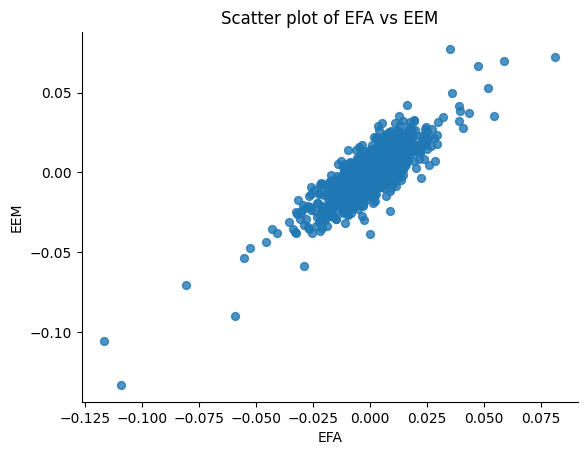

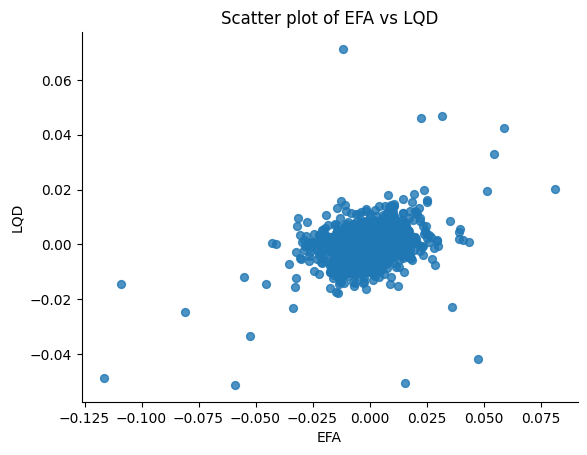

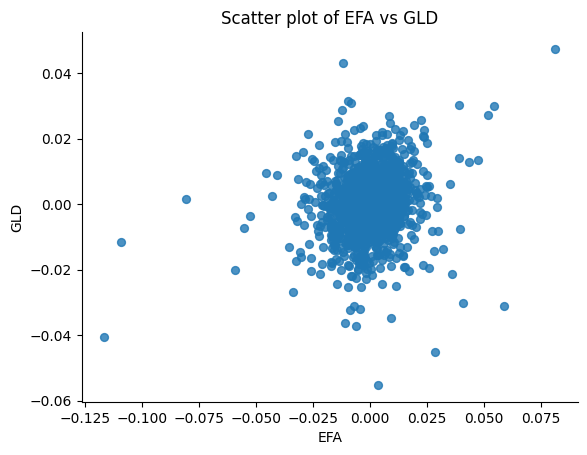

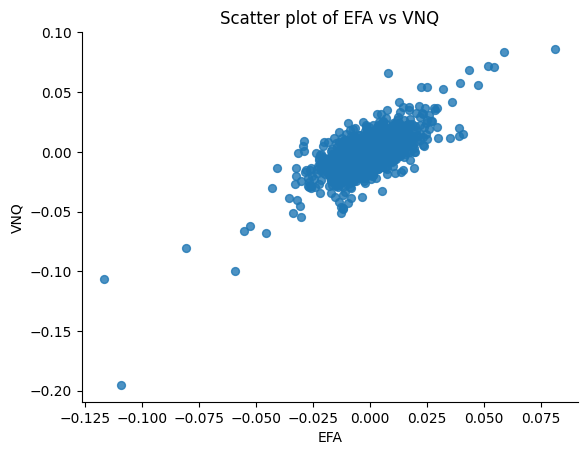

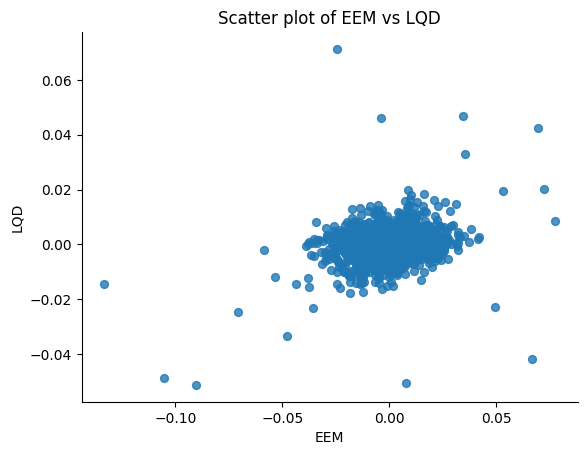

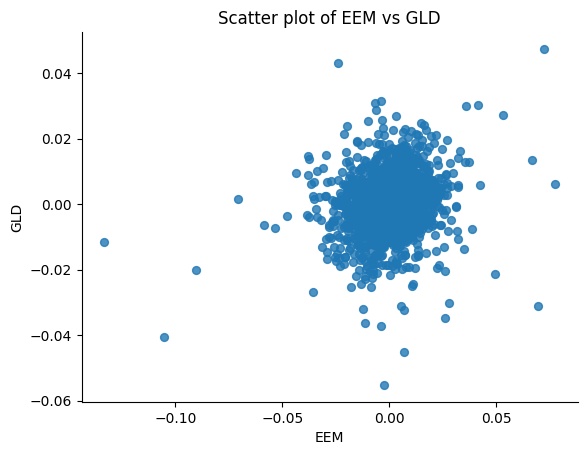

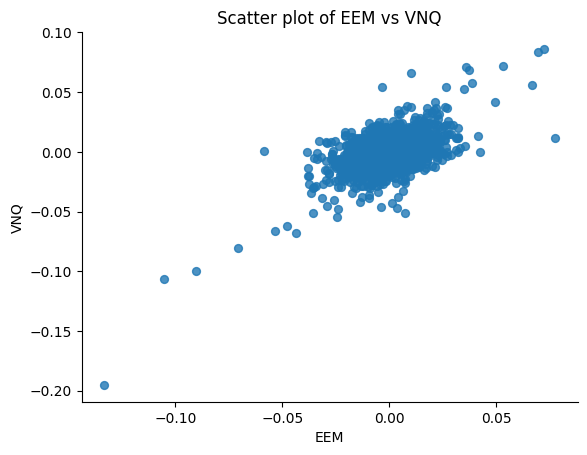

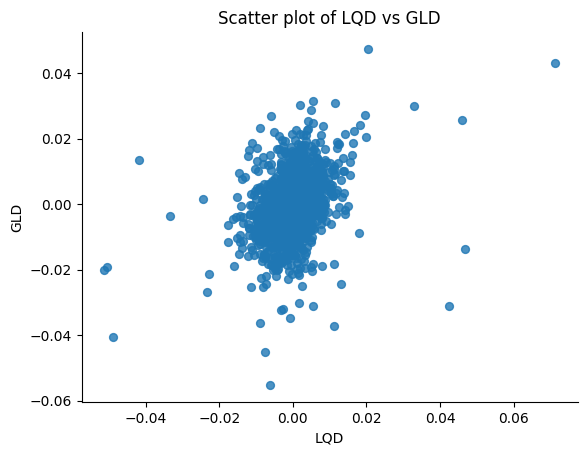

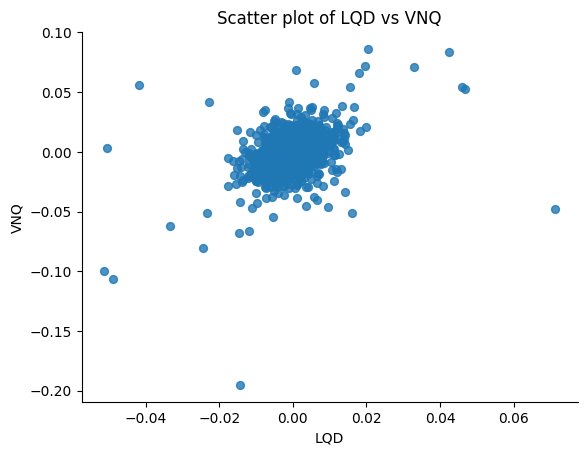

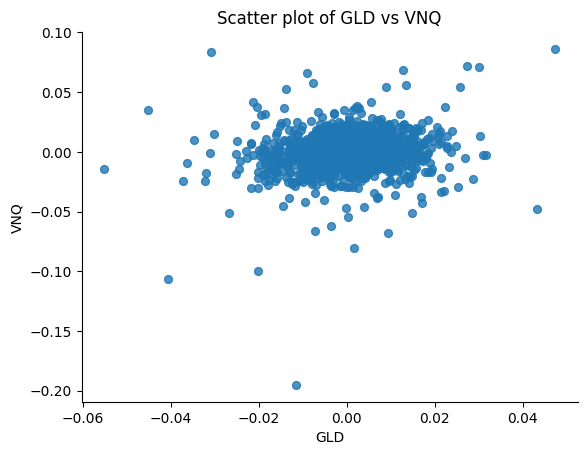

In [ ]:
columns = tickers = ["EFA", "EEM", "LQD", "GLD", "VNQ"]
combinations = list(itertools.combinations(columns, 2))

# create a scatter plot for each combination
for (x, y) in combinations:
    log_returns.plot(kind='scatter', x=x, y=y, s=32, alpha=0.8)
    plt.gca().spines[['top', 'right']].set_visible(False)
    plt.title(f'Scatter plot of {x} vs {y}')
    plt.show()


The scatter plots visualize the relationships between the log returns of pairs of selected tickers: EFA, EEM, LQD, GLD, and VNQ. Positive correlations, such as between EFA and EEM, indicate similar movements, while weaker correlations, like between EFA and LQD, suggest diversification benefits. The plots help understand how different assets move in relation to each other, which is crucial for building a diversified portfolio.

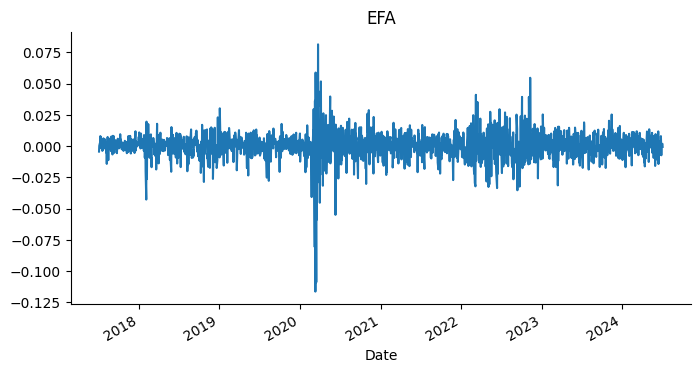

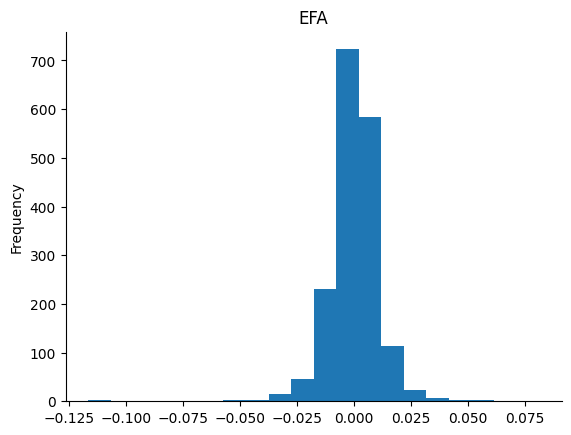

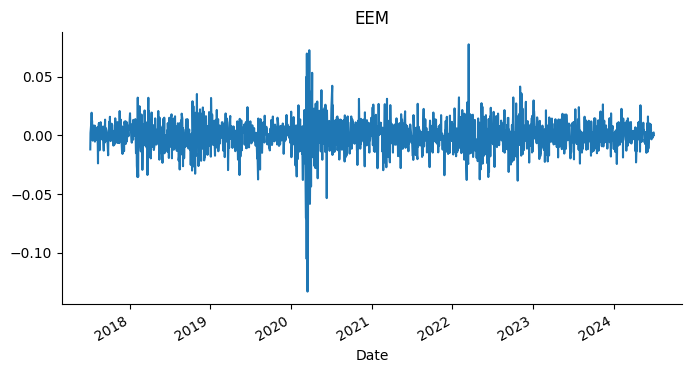

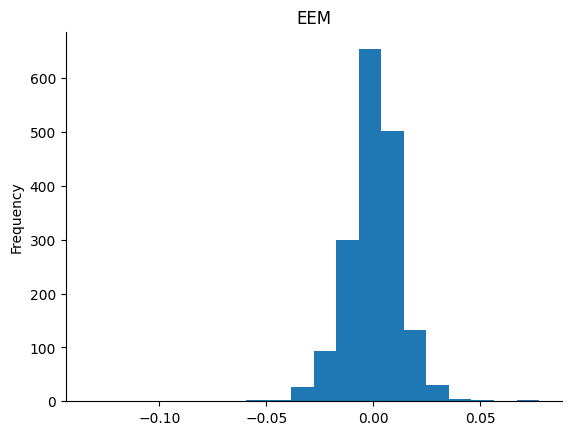

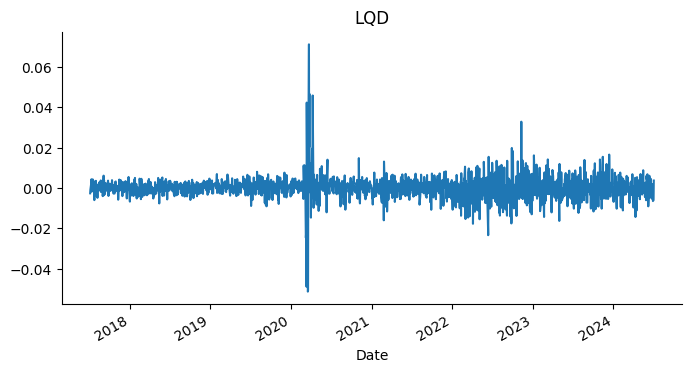

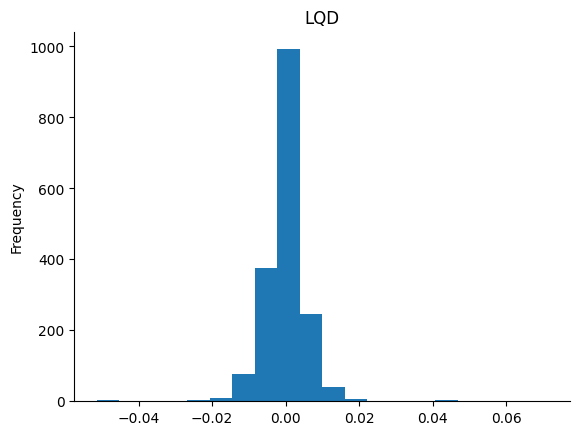

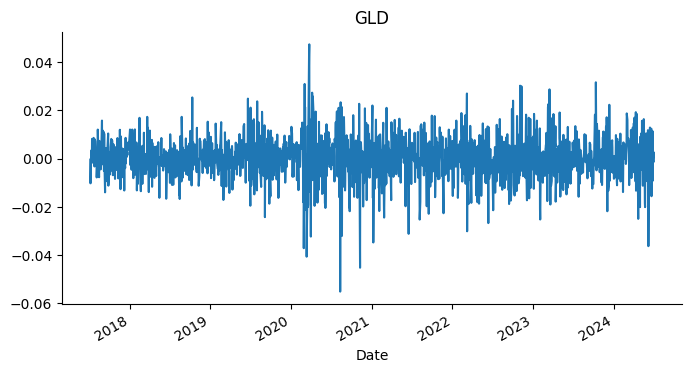

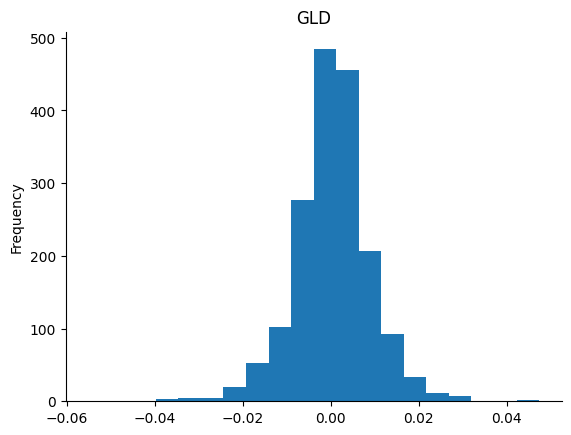

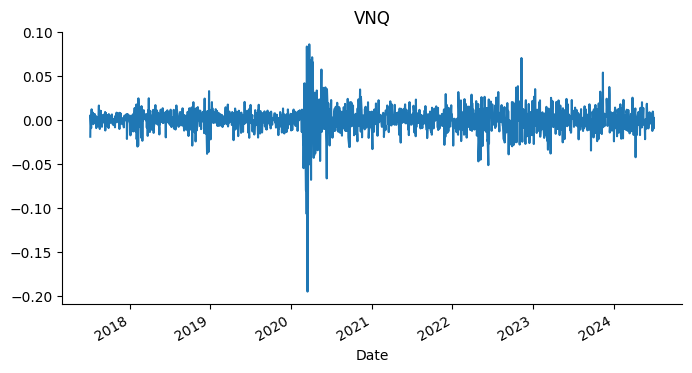

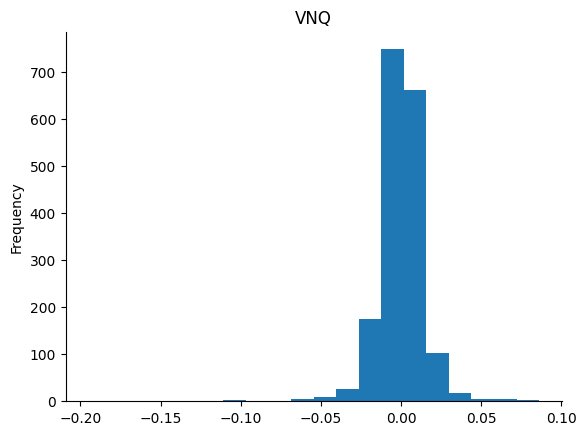

In [ ]:
for col in columns:
    # line plot
    log_returns[col].plot(kind='line', figsize=(8, 4), title=col)
    plt.gca().spines[['top', 'right']].set_visible(False)
    plt.show()

    # histogram
    log_returns[col].plot(kind='hist', bins=20, title=col)
    plt.gca().spines[['top', 'right']].set_visible(False)
    plt.show()

The line plots for EFA, EEM, LQD, GLD, and VNQ depict daily log returns, highlighting fluctuations over time. EEM and VNQ exhibit higher volatility with more significant spikes, especially around 2020, compared to the relatively stable returns of EFA, LQD, and GLD. LQD shows the least volatility, indicating a lower risk profile, while GLD acts as a safer asset during market downturns with frequent but smaller fluctuations.

The histograms provide the frequency distribution of log returns, showing most returns clustering around zero. EEM and VNQ have wider distributions, indicating higher volatility and a greater likelihood of extreme returns, while LQD’s distribution is tightly centered around zero, reflecting lower risk. GLD shows a narrow distribution with longer tails than LQD, suggesting occasional significant returns. This comparative analysis highlights the varying risk and return characteristics of the assets.

In [ ]:
#calculate mean of log returns
mean_log_returns = log_returns.mean() * 252

print("Mean log returns:")
print(mean_log_returns)

Mean log returns:
Ticker
EEM    0.026427
EFA    0.055831
GLD    0.087973
LQD    0.015852
VNQ    0.039666
dtype: float64


In [ ]:
# calculate standard deviation of log returns (annualized)
cov_matrix = log_returns.cov() * 252
print("\nCovariance matrix (annualized):")
print(cov_matrix)


Covariance matrix (annualized):
Ticker       EEM       EFA       GLD       LQD       VNQ
Ticker                                                  
EEM     0.044963  0.031848  0.005780  0.005649  0.028387
EFA     0.031848  0.032267  0.004814  0.005847  0.029354
GLD     0.005780  0.004814  0.019469  0.004610  0.004750
LQD     0.005649  0.005847  0.004610  0.009213  0.008755
VNQ     0.028387  0.029354  0.004750  0.008755  0.052374


##Portfolio Optimization

Calculate Portfolio Performance

In [ ]:
# define the function to calculate portfolio performance
def portfolio_performance(weights, mean_log_returns, cov_matrix):
    returns = np.sum(mean_log_returns * weights)  # Annualized return
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))  # Annualized standard deviation
    return returns, std

In [ ]:
# define the function to minimize the negative Sharpe Ratio
def neg_sharpe_ratio(weights, mean_log_returns, cov_matrix, risk_free_rate):
    p_returns, p_std = portfolio_performance(weights, mean_log_returns, cov_matrix)
    return -(p_returns - risk_free_rate) / p_std


In [ ]:
# define the function to minimize portfolio variance
def minimize_variance(weights, mean_log_returns, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)

In [ ]:
risk_free_rate = 0.02

In [ ]:
# optimization function
def optimize_portfolio(mean_log_returns, cov_matrix, risk_free_rate, optimization_type='sharpe'):
    num_assets = len(mean_log_returns)
    args = (mean_log_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0, 0.3)
    bounds = tuple(bound for asset in range(num_assets))

    if optimization_type == 'sharpe':
        result = minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    elif optimization_type == 'variance':
        result = minimize(minimize_variance, num_assets*[1./num_assets,], args=(mean_log_returns, cov_matrix), method='SLSQP', bounds=bounds, constraints=constraints)
    else:
        raise ValueError("Unknown optimization type. Use 'sharpe' or 'variance'.")

    return result


In [ ]:
# perform optimization
risk_free_rate = 0.02
result = optimize_portfolio(mean_log_returns, cov_matrix, risk_free_rate, optimization_type='sharpe')

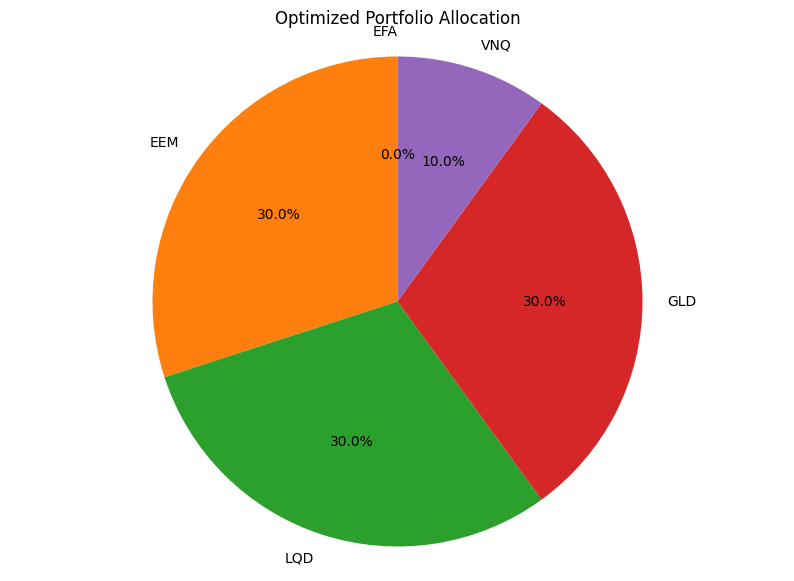

In [ ]:
# visualize the optimized portfolio allocation
optimized_weights = result.x
plt.figure(figsize=(10, 7))
plt.pie(optimized_weights, labels=tickers, autopct='%1.1f%%', startangle=90)
plt.title('Optimized Portfolio Allocation')
plt.axis('equal')
plt.show()

##Explanation##
The portfolio optimization was performed using the Sharpe Ratio as the objective function. The optimization resulted in the following allocations:
- 30% in EEM (Emerging Markets)
- 30% in LQD (Investment Grade Corporate Bonds)
- 30% in GLD (Gold)
- 10% in VNQ (U.S. Real Estate)
- 0% in EFA (Developed Markets)

This allocation suggests that the optimizer favors a high allocation to emerging markets, corporate bonds, and gold, while avoiding developed markets. This could be due to the risk-return profile of the assets over the given period.


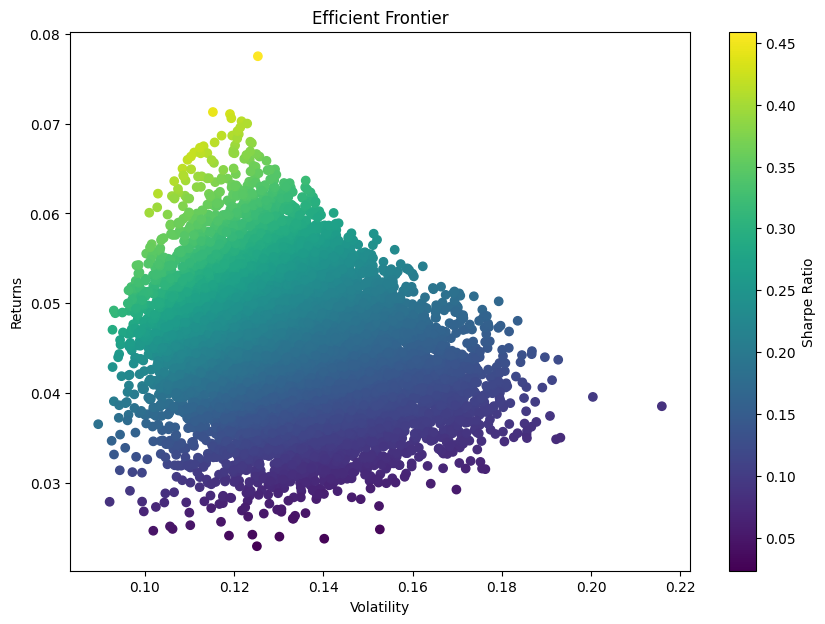

In [ ]:
# visualize the Efficient Frontier
def plot_efficient_frontier(mean_log_returns, cov_matrix, risk_free_rate):
    results = {'Returns': [], 'Volatility': [], 'Sharpe Ratio': [], 'Weights': []}
    for _ in range(10000):
        weights = np.random.random(len(mean_log_returns))
        weights /= np.sum(weights)
        returns, volatility = portfolio_performance(weights, mean_log_returns, cov_matrix)
        sharpe_ratio = (returns - risk_free_rate) / volatility
        results['Returns'].append(returns)
        results['Volatility'].append(volatility)
        results['Sharpe Ratio'].append(sharpe_ratio)
        results['Weights'].append(weights)

    results_df = pd.DataFrame(results)
    plt.figure(figsize=(10, 7))
    plt.scatter(results_df['Volatility'], results_df['Returns'], c=results_df['Sharpe Ratio'], cmap='viridis')
    plt.colorbar(label='Sharpe Ratio')
    plt.xlabel('Volatility')
    plt.ylabel('Returns')
    plt.title('Efficient Frontier')
    plt.show()

plot_efficient_frontier(mean_log_returns, cov_matrix, risk_free_rate)

##Efficient Frontier##
The Efficient Frontier illustrates the optimal portfolios that offer the highest expected return for a given level of risk. It demonstrates the trade-off between risk (volatility) and return, where portfolios on the upper edge of the curve are considered optimal. The color of the points represents the Sharpe Ratio, with brighter colors indicating better risk-adjusted returns. This visualization shows the benefits of diversification, as combining different assets can achieve a more favorable risk-return profile than individual assets alone.

##Conclusion##
This project effectively optimized a portfolio of EFA, EEM, LQD, GLD, and VNQ. Analysis showed EEM and VNQ have higher volatility, while LQD and GLD have lower risk profiles. The optimized allocation favored EEM, LQD, and GLD at 30% each, with 10% in VNQ, achieving a strategic balance. The Efficient Frontier highlighted diversification benefits, maximizing returns while minimizing risk.
